## Data Cleaning and Preprocessing

This notebook aims to clean and preprocess the dataset, prepare a dataset ready for model building.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.functions import director_anonymisation, ignore_na

In [2]:
df = pd.read_csv("data/Projects - Quote Data.csv", na_values="", keep_default_na=False)

In [3]:
# Dropping and anonymising certain columns to protect personal data
df.drop(["Project No", "Project Address", "Postcode"], axis=1, inplace=True)
director_anonymisation(df, "Director")
df.tail(7)

,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value
43,B,11,11,5,16,8.00,27.0,NaN,-2,"£1,200,000"
44,A,15,26,13,58,9.30,-16.2,0,-4.26,"£1,736,179"
45,A,12,15,8,28,13.00,NaN,NaN,-6,"£567,845"
46,B,13,23,6,27,7.00,0.0,0,14,"£1,421,015"
47,A,15,21,7,35,6.50,NaN,NaN,-13.22,"£1,571,186"
48,B,11,15,7,35,12.00,1.0,4,-9,"£1,167,178"
49,A,7,13,2,59,5.44,NaN,0,-12.5,"£1,306,986"


### 1. Reshaping the Dataframe

I intend to reshape the dataframe from a wide format (observation as per project), to a long format - so that each stage of a project become their own observation. This is to prepare the stage number so it can be used as a feature.

In [4]:
quoted_hours = df.melt(id_vars=["Director", "Current Est Value"],
                       value_vars=["Stage 1", "Stage 2", "Stage 3", "Stage 4"],
                       var_name="Stage",
                       value_name="Quoted Hours")

In [5]:
ot_hours = df.melt(id_vars=["Director", "Current Est Value"],
                   value_vars=["Stage 1 OT", "Stage 2 OT", "Stage 3 OT", "Stage 4 OT"],
                   var_name="Stage OT",
                   value_name="Overtime Hours",)

In [6]:
# Cleaning the entries for Stage column of Quoted Hours dataframe
quoted_hours["Stage"] = quoted_hours["Stage"].str.replace("Stage ", "").astype(int)

quoted_hours.head()

,Director,Current Est Value,Stage,Quoted Hours
0,B,"£1,065,733",1,4
1,A,"£510,554",1,12
2,A,"£747,169",1,13
3,B,"£1,520,156",1,12
4,A,"£658,430",1,12


In [7]:
# Cleaning the entries for Stage column for OT dataframe
ot_hours["Stage"] = ot_hours["Stage OT"].str.replace("Stage ", "").str.replace(" OT", "").astype(int)
ot_hours.drop(columns=["Stage OT"], inplace=True)

ot_hours.head()

,Director,Current Est Value,Overtime Hours,Stage
0,B,"£1,065,733",1.0,1
1,A,"£510,554",2.8,1
2,A,"£747,169",7.0,1
3,B,"£1,520,156",9.3,1
4,A,"£658,430",-1.2,1


In [8]:
# Omitting observations with "Not Applicable" hours
ignore_na(quoted_hours, "Quoted Hours", "N/A")
ignore_na(ot_hours, "Overtime Hours", "N/A")

print(quoted_hours.shape, ot_hours.shape)

(192, 4) (191, 4)


In [9]:
# Merging the two dataframes
train_df = pd.merge(quoted_hours, ot_hours, on=["Director", "Current Est Value", "Stage"])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Director           197 non-null    object
 1   Current Est Value  197 non-null    object
 2   Stage              197 non-null    int64 
 3   Quoted Hours       197 non-null    object
 4   Overtime Hours     187 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.8+ KB


### 2. Encoding and Converting Non-numeric Columns

In [10]:
# Encoding "Director" column
train_df = pd.get_dummies(train_df, columns=["Director"])
train_df.head()

,Current Est Value,Stage,Quoted Hours,Overtime Hours,Director_A,Director_B
0,"£1,065,733",1,4,1.0,False,True
1,"£510,554",1,12,2.8,True,False
2,"£747,169",1,13,7.0,True,False
3,"£1,520,156",1,12,9.3,False,True
4,"£658,430",1,12,-1.2,True,False


In [11]:
# Convert non-numeric columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Current Est Value  197 non-null    object
 1   Stage              197 non-null    int64 
 2   Quoted Hours       197 non-null    object
 3   Overtime Hours     187 non-null    object
 4   Director_A         197 non-null    bool  
 5   Director_B         197 non-null    bool  
dtypes: bool(2), int64(1), object(3)
memory usage: 6.7+ KB


In [12]:
train_df["Current Est Value"] = train_df["Current Est Value"].replace('[\£,]', '', regex=True).astype(int)

float_cols = [c for c in train_df.columns if "Hour" in c]
train_df[float_cols] = train_df[float_cols].astype(np.float32)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Current Est Value  197 non-null    int64  
 1   Stage              197 non-null    int64  
 2   Quoted Hours       197 non-null    float32
 3   Overtime Hours     187 non-null    float32
 4   Director_A         197 non-null    bool   
 5   Director_B         197 non-null    bool   
dtypes: bool(2), float32(2), int64(2)
memory usage: 5.1 KB


### 3. Dealing with Missing Values

In [13]:
# checking the missing values
train_df.isnull().sum()

Current Est Value     0
Stage                 0
Quoted Hours          0
Overtime Hours       10
Director_A            0
Director_B            0
dtype: int64

In [14]:
# Selecting the observations with missing values
train_df.loc[train_df["Overtime Hours"].isnull()]

,Current Est Value,Stage,Quoted Hours,Overtime Hours,Director_A,Director_B
37,688090,1,8.0,NaN,True,False
84,823000,2,15.0,NaN,True,False
99,567845,2,15.0,NaN,True,False
101,1571186,2,21.0,NaN,True,False
103,1306986,2,13.0,NaN,True,False
137,1090000,3,4.0,NaN,True,False
139,1003232,3,4.0,NaN,True,False
147,1200000,3,5.0,NaN,False,True
149,567845,3,8.0,NaN,True,False
151,1571186,3,7.0,NaN,True,False


I intend to impute these overtime hours entries, based on the average overtime hours are worked for their corresponding stage.

In [15]:
# Obtain the average overtime hours for each stage
avg_ot = train_df.groupby("Stage")["Overtime Hours"].mean()
avg_ot = avg_ot.to_dict()
avg_ot

{1: 6.349803924560547, 2: 7.4375, 3: 3.3182220458984375, 4: 2.8565115928649902}

In [16]:
avg_ot = train_df.groupby("Stage")["Overtime Hours"].transform("mean").round(2)

# Fill missing "Overtime Hours" with stage-wise averages
train_df["Overtime Hours"] = train_df["Overtime Hours"].fillna(avg_ot)

print(train_df.isnull().sum())

Current Est Value    0
Stage                0
Quoted Hours         0
Overtime Hours       0
Director_A           0
Director_B           0
dtype: int64


### 4. Preparing Features & Target Variables

In [17]:
train_df.head()

,Current Est Value,Stage,Quoted Hours,Overtime Hours,Director_A,Director_B
0,1065733,1,4.0,1.0,False,True
1,510554,1,12.0,2.8,True,False
2,747169,1,13.0,7.0,True,False
3,1520156,1,12.0,9.3,False,True
4,658430,1,12.0,-1.2,True,False


In [18]:
# Creating a "y" variable
train_df["Predicted Total Hours"] = train_df[["Quoted Hours", "Overtime Hours"]].sum(axis=1)

# Dropping the overtime column as it's not required for the model 
train_df.drop("Overtime Hours", axis=1, inplace=True)
train_df.head()

,Current Est Value,Stage,Quoted Hours,Director_A,Director_B,Predicted Total Hours
0,1065733,1,4.0,False,True,5.000000
1,510554,1,12.0,True,False,14.800000
2,747169,1,13.0,True,False,20.000000
3,1520156,1,12.0,False,True,21.299999
4,658430,1,12.0,True,False,10.800000


In [19]:
# Encoding "Stage" column
train_df = pd.get_dummies(train_df, columns=["Stage"])
train_df.head()

,Current Est Value,Quoted Hours,Director_A,Director_B,Predicted Total Hours,Stage_1,Stage_2,Stage_3,Stage_4
0,1065733,4.0,False,True,5.000000,True,False,False,False
1,510554,12.0,True,False,14.800000,True,False,False,False
2,747169,13.0,True,False,20.000000,True,False,False,False
3,1520156,12.0,False,True,21.299999,True,False,False,False
4,658430,12.0,True,False,10.800000,True,False,False,False


In [20]:
# Move the y variable to the last column
train_df["Predicted Total Hours"] = train_df.pop("Predicted Total Hours")
train_df.head()

,Current Est Value,Quoted Hours,Director_A,Director_B,Stage_1,Stage_2,Stage_3,Stage_4,Predicted Total Hours
0,1065733,4.0,False,True,True,False,False,False,5.000000
1,510554,12.0,True,False,True,False,False,False,14.800000
2,747169,13.0,True,False,True,False,False,False,20.000000
3,1520156,12.0,False,True,True,False,False,False,21.299999
4,658430,12.0,True,False,True,False,False,False,10.800000


<Axes: >

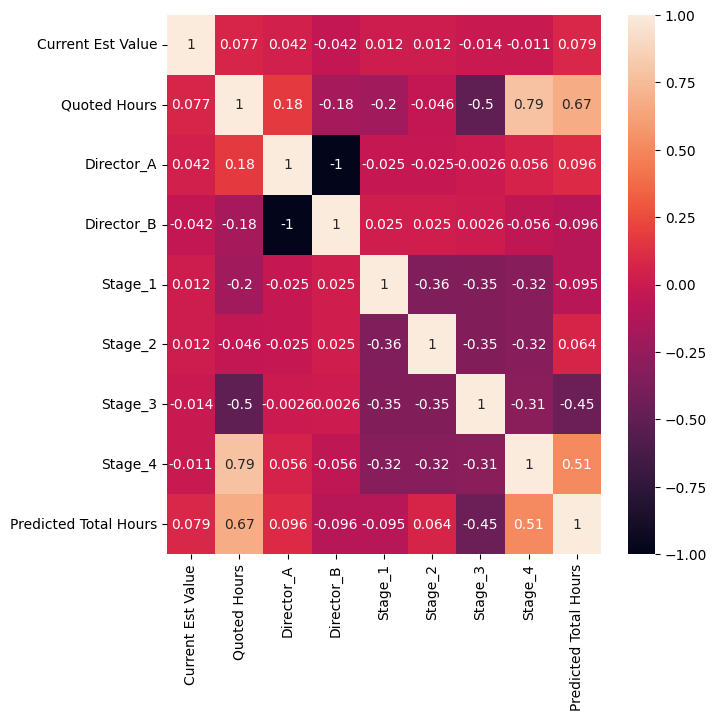

In [21]:
# Looking at correlation between features
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(train_df.corr(), annot = True)

In [22]:
# Exporting to csv file
train_df.to_csv("data/data.csv", index=False)